In [2]:
from datetime import datetime
import pathlib
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers.tempcomp_helper import get_comp_factors
from helpers.tempcomp_helper import get_comp_factors_nonzero
from helpers.tempcomp_helper import add_compensated_data_to_df
from helpers.tempcomp_helper import add_compensated_data_to_df_infrequent

In [3]:
test_date = "08_01_2022"
test_folder = "preliminary"
test_name = "normalized_heating_pretest_rtd-str_Jan2023"
# test_date = "08_01_2022"
# test_folder = "Day1_Training1"
# test_name = "normalized_WTRUN2_training_sweep1_2022-08-01_17-24-43-50_rtd-str_Jan2023"
# test_date = "08_02_2022"
# test_folder = "Day2_Training1"
# test_name = "normalized_WTRUN2_day2_training1_2022-08-02_12-38-30-01_rtd-str_Jan2023"
# test_date = "08_02_2022"
# test_folder = "Day2_Dynamic1"
# test_name = "normalized_WTRUN2_day2_dynamic1_2022-08-02_14-32-54-11_rtd-str_Jan2023"

cur_dir = os.getcwd()
par_dir = os.path.abspath(os.path.join(cur_dir, os.pardir))
up_dir = os.path.dirname(par_dir)
compfactor_dir = os.path.join(up_dir, "08_01_2022_Tests", "testdata", "preliminary")
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
test_csv = os.path.join(data_dir, test_name+".csv")

if "normalized" not in test_csv:
  _ = input("The .csv file is not normalized. Are you sure you'd like to continue?")

test_df = pd.read_csv(test_csv, header=1) #header=1 for normalized SGs/RTDs. header=0 for non-normalized

# 1a) Get Comp Factors for Heating

The block below computes the compensation factors and exports them in .pickle format

In [ ]:
if "heating_pretest" not in test_name:
  _ = input("""You're trying to set compensation factors from a 
            different test than the controlled pre-heating test. 
            This is very likely not what you should do! Are you sure?""")

sensor_id_list = [1, 2, 4, 5, 6]
unique_rtds = True #Set whether we'd like to find compensation factors using unique RTDs or shared RTDs
comp_factors = get_comp_factors(test_df, sensor_id_list, unique_rtds)

In [19]:
comp_factors[1]

[-1.182597936664619e-06,
 0.08294487613176664,
 3.3128509456870243,
 -315.3447629126262]

# 1b) Get Comp Factors for Cooling

In [48]:
# Get the average strain and lift from the test that gave sensible readings
# (Day2Training1)

time_range = (datetime(2022,8,2,12,39,00), datetime(2022,8,2,12,58,00))
SG_cols_comp = ["SG 1 (V) (normalized) (compensated)",
                "SG 2 (V) (normalized) (compensated)", 
                "SG 4 (V) (normalized) (compensated)", 
                "SG 5 (V) (normalized) (compensated)", 
                "SG 6 (V) (normalized) (compensated)"]

# strain
test_date = "08_02_2022"
test_folder = "Day2_Training1"
test_name = "compensated_normalized_WTRUN2_day2_training1_2022-08-02_12-38-30-01_rtd-str_Jan2023"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=0)
sg_df.insert(1, "Date/Time (formatted)", sg_df["Date/Time"])
sg_df["Date/Time (formatted)"] = sg_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d_%H-%M-%S-%f"))
sg_df_filtered = sg_df[(sg_df["Date/Time (formatted)"] > time_range[0]) & (sg_df["Date/Time (formatted)"] < time_range[1])].reset_index()

# lift
test_name = "DateTimed_WTRUN2_day2_training1_EDS"
eds_csv = os.path.join(data_dir, test_name+".csv")
eds_df = pd.read_csv(eds_csv, header=0, index_col=False)
eds_df.insert(1, "Date/Time (formatted)", eds_df["DateTime Str"])
eds_df["Date/Time (formatted)"] = eds_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
eds_df_filtered = eds_df[(eds_df["Date/Time (formatted)"] > time_range[0]) & (eds_df["Date/Time (formatted)"] < time_range[1])].reset_index()

In [49]:
# Undersample the SGs so that the number of samples btw SG and EDS matches.
sg_indices = list()
for i in range(eds_df_filtered.shape[0]):
  ix = sg_df_filtered['Date/Time (formatted)'].sub(eds_df_filtered.loc[i,["Date/Time (formatted)"]][0]).abs().idxmin()
  sg_indices.append(ix)

sg_df_filtered = sg_df_filtered.iloc[sg_indices]
sg_df_filtered = sg_df_filtered[SG_cols_comp].reset_index(drop=True)

In [78]:
sg_df_filtered = sg_df_filtered.rename(columns=lambda x: x[0:4])
lift_to_str_ratios = (1/sg_df_filtered).mul(eds_df_filtered["Lift (lbf)"], axis=0)
str_to_liftratios = (sg_df_filtered).div(eds_df_filtered["Lift (lbf)"], axis=0)

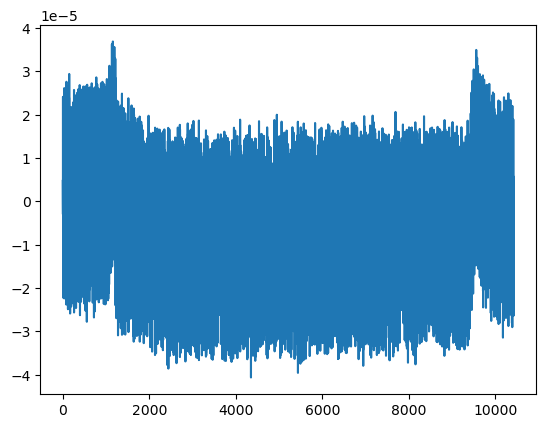

In [71]:
plt.plot(sg_df_filtered["SG 1"])

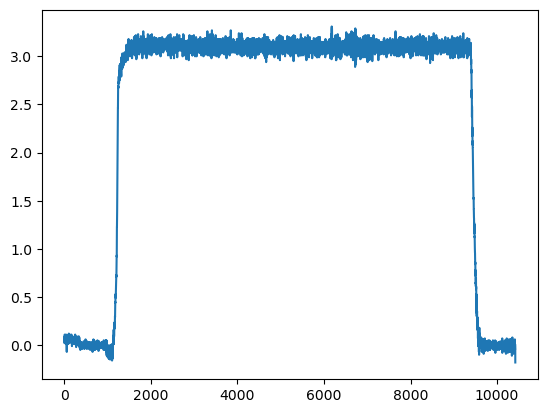

In [72]:
plt.plot(eds_df_filtered["Lift (lbf)"])

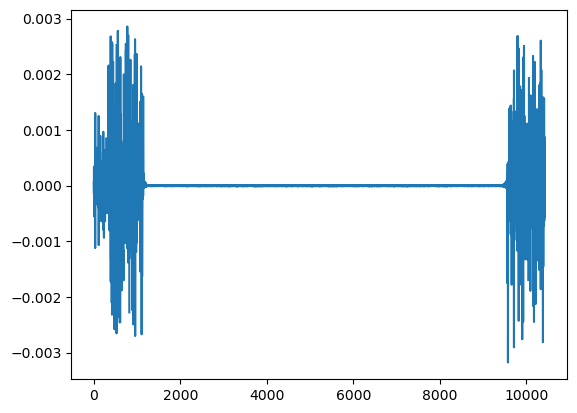

In [79]:
plt.plot(lift_to_str_ratios["SG 1"])

In [80]:
# Get the average lift from the test that didn't give sensible readings
# Then calculate the expected average strain based on the lift_to_str_ratios found above
# (Day2Dynamic1)

time_range_0 = (datetime(2022,8,2,14,33,00), datetime(2022,8,2,14,34,20))
time_range_1 = (datetime(2022,8,2,14,34,50), datetime(2022,8,2,14,49,40))
time_range_2 = (datetime(2022,8,2,14,50,10), datetime(2022,8,2,14,51,50))

# lift
test_date = "08_02_2022"
test_folder = "Day2_Dynamic1"
test_name = "DateTimed_WTRUN2_day2_dynamic1_EDS"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
eds_csv = os.path.join(data_dir, test_name+".csv")
eds_df = pd.read_csv(eds_csv, header=0, index_col=False)
eds_df.insert(1, "Date/Time (formatted)", eds_df["DateTime Str"])
eds_df["Date/Time (formatted)"] = eds_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
eds_df_filtered = eds_df[eds_df["Date/Time (formatted)"] < time_range_2[1]]

ave_lift_nonsensible_0 = 0
ave_lift_nonsensible_1 = eds_df_filtered[(eds_df_filtered["Date/Time (formatted)"] > time_range_1[0]) & (eds_df_filtered["Date/Time (formatted)"] < time_range_1[1])]
ave_lift_nonsensible_1 = np.mean(ave_lift_nonsensible_1["Lift (lbf)"])
ave_lift_nonsensible_2 = 0

# expected strain
exp_str_1 = ave_lift_nonsensible_1/lift_to_str_ratios

In [81]:
# Finally, compute the compensation factors that'll pull the strain values around the expected average strain found above
# (similar to the earlier compensation, but this time we're minimizing around the non-zero values found above)

# observed strain
test_date = "08_02_2022"
test_folder = "Day2_Dynamic1"
test_name = "normalized_WTRUN2_day2_dynamic1_2022-08-02_14-32-54-11_rtd-str_Jan2023"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=1)
sg_df.insert(1, "Date/Time (formatted)", sg_df["Date/Time"])
sg_df["Date/Time (formatted)"] = sg_df["Date/Time (formatted)"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d_%H-%M-%S-%f"))

sg_df_filtered = sg_df[sg_df["Date/Time (formatted)"] < time_range_2[1]]
sg_df_filtered.insert(1,"SG 1 Expected", 0)
sg_df_filtered.loc[(sg_df_filtered["Date/Time (formatted)"] > time_range_1[0]) & (sg_df_filtered["Date/Time (formatted)"] < time_range_1[1]), "SG 1 Expected"] = exp_str_1['SG 1']

sensor_id_list = [1] 
exp_str = sg_df_filtered["SG 1 Expected"] 
comp_factors = get_comp_factors_nonzero (sg_df_filtered, sensor_id_list, exp_str)


   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-9.08967788e-04, -1.26326744e-01,  1.55734104e+00,
        -1.54297537e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-7.48150872e-07, -1.97333845e-02, -1.64040221e+00,
         2.13535774e+02]])
     fun: 0.264192002686343
 message: 'Optimization terminated successfully.'
    nfev: 356
     nit: 6
  status: 0
 success: True
       x: array([ 1.08722549e-06,  7.28868619e-02, -8.85436315e-02,  6.92355409e+01])


In [37]:
comp_factors

{1: [-4.22462735403518e-05,
  -0.3700672184315046,
  -145.172920031471,
  -11801.81706751415]}

In [39]:
# Validation 1: check the accuracy of these factors in the non-sensible test
# (Day2Dynamic1)
# observed strain
test_date = "08_02_2022"
test_folder = "Day2_Dynamic1"
test_name = "normalized_WTRUN2_day2_dynamic1_2022-08-02_14-32-54-11_rtd-str_Jan2023"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=1)

sg_df_comp = add_compensated_data_to_df (sg_df, comp_factors, True)


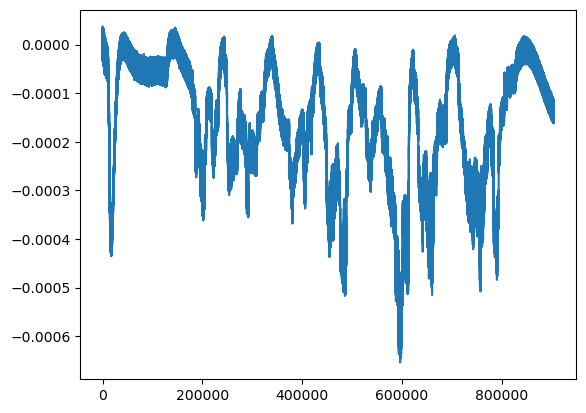

In [40]:
plt.plot(sg_df_comp["SG 1 (V) (normalized) (compensated)"])

In [ ]:
# Validation 2: Check the accuracy of these factors in the other non-sensible test
# (Day1Training1)

# End of compensation factor calculation

In [41]:
unique_rtds = True
if not unique_rtds: #If we only have RTD 1 and RTD 6 available
  data_name = "compfactors_sharedRTDs.pickle"
else:
  data_name = "compfactors_Jan2023_tworegion.pickle"

with open(os.path.join(compfactor_dir, data_name), 'wb') as f:
  pickle.dump(comp_factors, f)

# 2) Add Compensated Strains
The block below computes the compensated data and creates a new .csv file with them in it.

In [42]:
if unique_rtds == False: #If we only have RTD 1 and RTD 6 available
  data_name = "compfactors_sharedRTDs.pickle"
else:
  data_name = "compfactors_Jan2023.pickle"

with open(os.path.join(compfactor_dir, data_name), 'rb') as f:
  comp_factors = pickle.load(f)

test_df_comp = add_compensated_data_to_df (test_df, comp_factors, unique_rtds)

compensated_csv = os.path.join(data_dir, "compensated_"+test_name+"_tworegion.csv")
test_df_comp.to_csv(compensated_csv, index=False)

In [43]:
# Temp only: Adding for the cooling region
unique_rtds = True #Set whether we'd like to find compensation factors using unique RTDs or shared RTDs

if unique_rtds == False: #If we only have RTD 1 and RTD 6 available
  data_name = "compfactors_sharedRTDs.pickle"
else:
  data_name = "compfactors_Jan2023_tworegion.pickle"

test_date = "08_02_2022"
test_folder = "Day2_Dynamic1"
test_name = "normalized_WTRUN2_day2_dynamic1_2022-08-02_14-32-54-11_rtd-str_Jan2023"
data_dir = os.path.join(up_dir, test_date+"_Tests", "testdata", test_folder)
sg_csv = os.path.join(data_dir, test_name+".csv")
sg_df = pd.read_csv(sg_csv, header=1)

with open(os.path.join(compfactor_dir, data_name), 'rb') as f:
  comp_factors = pickle.load(f)

test_df_comp = add_compensated_data_to_df (sg_df, comp_factors, unique_rtds)

compensated_csv = os.path.join(data_dir, "compensated_"+test_name+"_tworegion.csv")
test_df_comp.to_csv(compensated_csv, index=False)